# Unit 5 - Financial Planning


In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC price
btc_data = requests.get(btc_url).json()
btc_price = btc_data['data']['1']['quotes']['USD']['price']

# Fetch current ETH price
eth_data = requests.get(eth_url).json()
eth_price = eth_data['data']['1027']['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $69849.60
The current value of your 5.3 ETH is $9605.51


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Following code used to check if keys are obtained. Used for diagnosis only.
#print(f"Alpaca Key type: {type(alpaca_api_key)}")
#print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [8]:
# Format current date as ISO format
today = pd.Timestamp("2021-03-19", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
df_portfolio = alpaca.get_barset(
    tickers,
    timeframe,
    start = today,
    end = today
).df

# Preview DataFrame
df_portfolio.head()

AGG                                     SPY  \
                            open    high     low  close   volume    open   
time                                                                       
2021-03-19 00:00:00-04:00  113.4  113.54  113.33  113.5  4674852  389.88   

                                                             
                              high     low  close    volume  
time                                                         
2021-03-19 00:00:00-04:00  391.569  387.15  389.5  93819590

In [9]:
# Pick AGG and SPY close prices
agg_close_price = float(df_portfolio['AGG']['close'])
spy_close_price = float(df_portfolio['SPY']['close'])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $113.5
Current SPY closing price: $389.5


In [10]:
# Compute the current value of shares
my_spy_value = spy_close_price * my_spy
my_agg_value = agg_close_price * my_agg

# Print current value of share
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $19475.00
The current value of your 200 AGG shares is $22700.00


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Create savings DataFrame
crypto_total = my_btc_value + my_eth_value
shares_total = my_spy_value + my_agg_value

df_prep = {
    'category' : ['crypto','shares'],
    'amount' : [crypto_total,shares_total]  
}

df_savings = pd.DataFrame(df_prep)
df_savings.set_index('category',inplace=True)

# Display savings DataFrame
display(df_savings)

amount
category           
crypto    79455.108
shares    42175.000

<AxesSubplot:title={'center':'Composition of Personal Savings'}, ylabel='amount'>

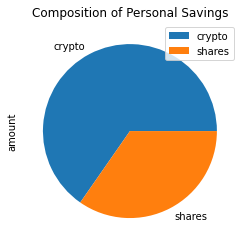

In [12]:
# Plot savings pie chart
df_savings.plot.pie(y="amount", title="Composition of Personal Savings")

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = float(df_savings.sum())
total_savings = 10

# Validate saving health
if total_savings > emergency_fund:
    print('Congrulations, you have enough money in the fund!')
elif total_savings == emergency_fund:
    print('Congrulations, you are on par with your emergency fund!')
elif total_savings < emergency_fund:
    print(f'You are {-(total_savings-emergency_fund)} away from your goal')

You are 35990 away from your goal


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-03-19', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-03-19', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
    limit = 1000 #please note as it's free account, if limit is not specified, it defaults to 100. Further, the maximum from a free acount call is 1000 lines.
).df

# Display sample data
df_stock_data.head()

AGG                                         SPY  \
                             open    high     low   close     volume     open   
time                                                                            
2017-03-29 00:00:00-04:00  108.48  108.62  108.46  108.60  1635068.0      NaN   
2017-03-30 00:00:00-04:00  108.52  108.58  108.38  108.41  1611863.0  235.490   
2017-03-31 00:00:00-04:00  108.44  108.53  108.42  108.52  3151075.0  235.905   
2017-04-03 00:00:00-04:00  108.31  108.68  108.30  108.67  3857775.0  235.800   
2017-04-04 00:00:00-04:00  108.61  108.65  108.52  108.56  1482935.0  235.000   

                                                                
                             high      low   close      volume  
time                                                            
2017-03-29 00:00:00-04:00     NaN      NaN     NaN         NaN  
2017-03-30 00:00:00-04:00  236.52  235.270  236.27  40604487.0  
2017-03-31 00:00:00-04:00  236.51  235.680  235.71  47583793.0  
2017-04-03 00:00:00-04:00  236.03  233.910  235.37  58627715.0  
2017-04-04 00:00:00-04:00  235.58  234.555  235.51  43130784.0

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_sim_portfolio = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [18]:
# Printing the simulation input data
MC_sim_portfolio.portfolio_data.head()

AGG                                     \
                             open    high     low   close     volume   
time                                                                   
2017-03-29 00:00:00-04:00  108.48  108.62  108.46  108.60  1635068.0   
2017-03-30 00:00:00-04:00  108.52  108.58  108.38  108.41  1611863.0   
2017-03-31 00:00:00-04:00  108.44  108.53  108.42  108.52  3151075.0   
2017-04-03 00:00:00-04:00  108.31  108.68  108.30  108.67  3857775.0   
2017-04-04 00:00:00-04:00  108.61  108.65  108.52  108.56  1482935.0   

                                            SPY                           \
                          daily_return     open    high      low   close   
time                                                                       
2017-03-29 00:00:00-04:00          NaN      NaN     NaN      NaN     NaN   
2017-03-30 00:00:00-04:00    -0.001750  235.490  236.52  235.270  236.27   
2017-03-31 00:00:00-04:00     0.001015  235.905  236.51  235.680  235.71   
2017-04-03 00:00:00-04:00     0.001382  235.800  236.03  233.910  235.37   
2017-04-04 00:00:00-04:00    -0.001012  235.000  235.58  234.555  235.51   

                                                    
                               volume daily_return  
time                                                
2017-03-29 00:00:00-04:00         NaN          NaN  
2017-03-30 00:00:00-04:00  40604487.0          NaN  
2017-03-31 00:00:00-04:00  47583793.0    -0.002370  
2017-04-03 00:00:00-04:00  58627715.0    -0.001442  
2017-04-04 00:00:00-04:00  43130784.0     0.000595

In [19]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_sim_portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2          3          4          5    \
0     1.000000  1.000000  1.000000   1.000000   1.000000   1.000000   
1     1.005366  1.031082  1.009610   0.991304   1.013401   0.991054   
2     1.026231  1.029035  1.014104   0.984700   1.018378   1.002111   
3     1.029782  1.028326  1.011643   0.980536   1.016038   0.995648   
4     1.020242  1.030219  1.002620   0.978926   1.015049   0.993217   
...        ...       ...       ...        ...        ...        ...   
7556  7.934221  7.961119  8.884557  14.932934  22.009407  11.172675   
7557  7.931119  7.776423  8.949624  14.784357  22.094476  11.237638   
7558  7.956938  7.768737  8.721807  14.851472  21.939002  11.375939   
7559  8.007185  7.719708  8.733572  14.763718  21.970780  11.290820   
7560  7.998981  7.700163  8.658078  15.018789  21.743408  11.248748   

            6          7          8          9    ...       490        491  \
0      1.000000   1.000000   1.000000   1.000000  ...  1.000000   1.000000   
1      0.990846   0.998615   0.985817   1.000606  ...  0.999000   0.995441   
2      0.980364   0.998775   0.969532   0.991631  ...  0.993983   1.000213   
3      0.987307   0.996019   0.976582   0.996795  ...  0.991669   1.016559   
4      0.988504   1.001289   0.970746   0.987196  ...  0.985638   1.016845   
...         ...        ...        ...        ...  ...       ...        ...   
7556  11.769731  14.329418  10.454935  11.992039  ...  9.269168  19.751199   
7557  11.784238  14.394748  10.531135  11.751554  ...  9.341536  19.836551   
7558  11.735418  14.848551  10.674097  11.721936  ...  9.355040  19.593471   
7559  11.711905  15.081678  10.806522  11.679002  ...  9.210197  19.531489   
7560  11.717146  15.135941  10.805481  11.827445  ...  9.083596  19.676232   

            492        493        494        495        496        497  \
0      1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
1      1.007980   1.011882   1.001710   1.007207   0.991401   1.010806   
2      1.021385   1.011824   1.018799   1.011287   0.989381   1.005412   
3      1.030873   1.012886   1.002951   1.019624   1.001527   1.006910   
4      1.027093   1.003742   0.999203   1.032782   1.008540   1.007249   
...         ...        ...        ...        ...        ...        ...   
7556  12.818343  15.019658  40.434706  32.686587  11.789004  11.066842   
7557  12.875965  15.206757  40.564257  32.790269  11.856917  11.114029   
7558  13.039690  15.270298  40.602294  32.784028  11.861274  11.120822   
7559  12.942811  15.365979  40.420199  32.615293  11.941444  11.113068   
7560  12.792567  15.490563  40.815213  32.695571  12.020688  11.118763   

            498       499  
0      1.000000  1.000000  
1      0.995173  0.999463  
2      0.998559  1.004997  
3      1.015102  1.004724  
4      1.019328  1.005236  
...         ...       ...  
7556  14.579980  6.710499  
7557  14.368884  6.601011  
7558  14.464561  6.576619  
7559  14.522922  6.601045  
7560  14.710517  6.692689  

[7561 rows x 500 columns]

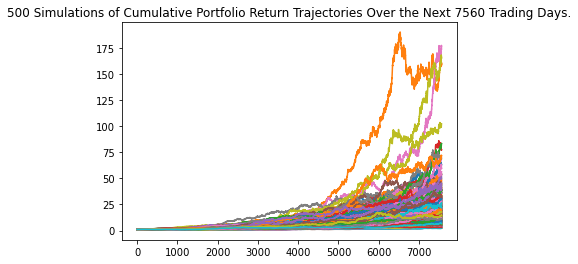

In [20]:
# Plot simulation outcomes
line_plot = MC_sim_portfolio.plot_simulation()

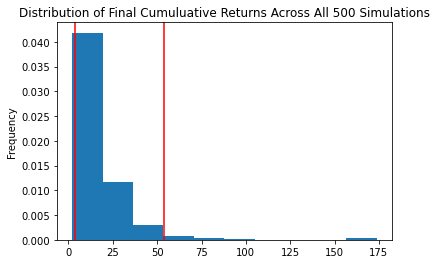

In [21]:
# Plot probability distribution and confidence intervals
dist_plot = MC_sim_portfolio.plot_distribution()

### Retirement Analysis

In [22]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_tbl = MC_sim_portfolio.summarize_cumulative_return()

# Print summary statistics
print(summary_tbl)

count           500.000000
mean             17.305130
std              17.151114
min               2.084454
25%               8.216492
50%              12.577583
75%              20.581888
max             173.650615
95% CI Lower      3.755617
95% CI Upper     53.855729
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a `$20,000` initial investment.

In [25]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(summary_tbl[8]*initial_investment,2)
ci_upper = round(summary_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $75112.33 and $1077114.58


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [26]:
# Set initial investment
initial_investment_50more = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower_50more = round(summary_tbl[8]*initial_investment_50more,2)
ci_upper_50more = round(summary_tbl[9]*initial_investment_50more,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_50more} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower_50more} and ${ci_upper_50more}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $112668.5 and $1615671.87


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [27]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_simulation_5years = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*5
)
MC_simulation_5years.portfolio_data.head()

AGG                                     \
                             open    high     low   close     volume   
time                                                                   
2017-03-29 00:00:00-04:00  108.48  108.62  108.46  108.60  1635068.0   
2017-03-30 00:00:00-04:00  108.52  108.58  108.38  108.41  1611863.0   
2017-03-31 00:00:00-04:00  108.44  108.53  108.42  108.52  3151075.0   
2017-04-03 00:00:00-04:00  108.31  108.68  108.30  108.67  3857775.0   
2017-04-04 00:00:00-04:00  108.61  108.65  108.52  108.56  1482935.0   

                                            SPY                           \
                          daily_return     open    high      low   close   
time                                                                       
2017-03-29 00:00:00-04:00          NaN      NaN     NaN      NaN     NaN   
2017-03-30 00:00:00-04:00    -0.001750  235.490  236.52  235.270  236.27   
2017-03-31 00:00:00-04:00     0.001015  235.905  236.51  235.680  235.71   
2017-04-03 00:00:00-04:00     0.001382  235.800  236.03  233.910  235.37   
2017-04-04 00:00:00-04:00    -0.001012  235.000  235.58  234.555  235.51   

                                                    
                               volume daily_return  
time                                                
2017-03-29 00:00:00-04:00         NaN          NaN  
2017-03-30 00:00:00-04:00  40604487.0          NaN  
2017-03-31 00:00:00-04:00  47583793.0    -0.002370  
2017-04-03 00:00:00-04:00  58627715.0    -0.001442  
2017-04-04 00:00:00-04:00  43130784.0     0.000595

In [28]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_simulation_5years.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.021302  1.011084  1.003464  0.996234  0.994101  1.000024  1.013057   
2     1.027292  1.009119  0.996427  1.010315  0.999202  1.000311  1.018304   
3     1.031083  1.012420  0.999616  1.007867  1.008214  0.999140  1.011466   
4     1.034012  1.009433  0.998219  1.006462  1.006853  1.009303  1.020067   
...        ...       ...       ...       ...       ...       ...       ...   
1256  2.072425  1.953040  0.969516  1.783774  3.636309  2.018704  1.385286   
1257  2.060034  1.960724  0.977325  1.771820  3.629883  2.019057  1.405277   
1258  2.067216  1.965830  0.982502  1.769164  3.597802  2.018422  1.405787   
1259  2.070641  1.969227  0.974426  1.754127  3.583545  2.012666  1.388293   
1260  2.066763  1.936659  0.974188  1.750117  3.593018  2.011288  1.396178   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.005214  1.011484  0.996159  ...  0.991728  1.003985  1.003438   
2     1.007710  1.021438  0.988787  ...  0.995896  1.005396  1.014023   
3     1.005199  1.021543  0.978747  ...  0.993879  0.998132  1.014798   
4     1.005733  1.027115  0.973407  ...  0.993460  1.011164  1.012167   
...        ...       ...       ...  ...       ...       ...       ...   
1256  2.163248  2.095454  2.491496  ...  1.127888  2.707493  1.448319   
1257  2.162068  2.084914  2.525016  ...  1.142899  2.741397  1.442791   
1258  2.179988  2.082199  2.510496  ...  1.148701  2.749182  1.448507   
1259  2.153490  2.069519  2.501146  ...  1.154460  2.758535  1.444060   
1260  2.163660  2.060570  2.513645  ...  1.148051  2.756297  1.451559   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.004411  1.011972  1.004477  0.990696  1.004789  0.989925  0.992858  
2     1.001745  1.018980  1.002446  0.982433  1.013827  0.981447  0.975393  
3     0.990301  1.024826  1.011831  0.981586  1.015594  0.976762  0.959728  
4     0.986049  1.026976  1.025081  0.991086  1.024099  0.988113  0.963969  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.092351  1.707769  1.419805  1.829174  1.766002  1.840470  0.935807  
1257  1.087388  1.715226  1.422186  1.821544  1.761347  1.842068  0.932535  
1258  1.090325  1.711551  1.433246  1.804811  1.773735  1.852799  0.939388  
1259  1.082998  1.737409  1.435067  1.818142  1.768302  1.860537  0.933939  
1260  1.082809  1.742230  1.441068  1.846236  1.791768  1.866370  0.915607  

[1261 rows x 500 columns]

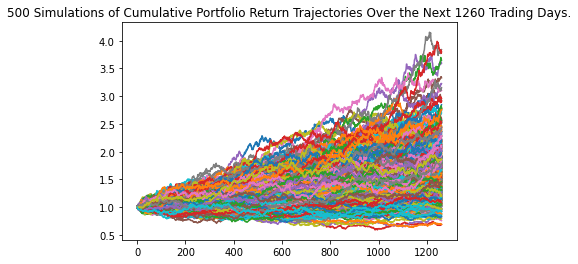

In [29]:
# Plot simulation outcomes
line_plot_5years = MC_simulation_5years.plot_simulation()

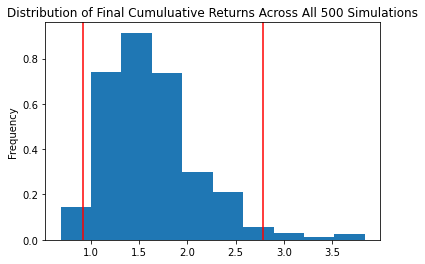

In [30]:
# Plot probability distribution and confidence intervals
dist_plot_5years = MC_simulation_5years.plot_distribution()

In [32]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_5years = MC_simulation_5years.summarize_cumulative_return()

# Print summary statistics
print(summary_5years)

count           500.000000
mean              1.635447
std               0.494531
min               0.687873
25%               1.290719
50%               1.556493
75%               1.879806
max               3.838693
95% CI Lower      0.924524
95% CI Upper      2.785306
Name: 1260, dtype: float64


In [33]:
# Set initial investment
initial_investment_cfo = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(summary_5years[8]*initial_investment_cfo,2)
ci_upper_five = round(summary_5years[9]*initial_investment_cfo,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_cfo} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $18490.48 and $55706.12


### Ten Years Retirement Option

In [34]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_simulation_10years = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*10
)
MC_simulation_10years.portfolio_data.head()

AGG                                     \
                             open    high     low   close     volume   
time                                                                   
2017-03-29 00:00:00-04:00  108.48  108.62  108.46  108.60  1635068.0   
2017-03-30 00:00:00-04:00  108.52  108.58  108.38  108.41  1611863.0   
2017-03-31 00:00:00-04:00  108.44  108.53  108.42  108.52  3151075.0   
2017-04-03 00:00:00-04:00  108.31  108.68  108.30  108.67  3857775.0   
2017-04-04 00:00:00-04:00  108.61  108.65  108.52  108.56  1482935.0   

                                            SPY                           \
                          daily_return     open    high      low   close   
time                                                                       
2017-03-29 00:00:00-04:00          NaN      NaN     NaN      NaN     NaN   
2017-03-30 00:00:00-04:00    -0.001750  235.490  236.52  235.270  236.27   
2017-03-31 00:00:00-04:00     0.001015  235.905  236.51  235.680  235.71   
2017-04-03 00:00:00-04:00     0.001382  235.800  236.03  233.910  235.37   
2017-04-04 00:00:00-04:00    -0.001012  235.000  235.58  234.555  235.51   

                                                    
                               volume daily_return  
time                                                
2017-03-29 00:00:00-04:00         NaN          NaN  
2017-03-30 00:00:00-04:00  40604487.0          NaN  
2017-03-31 00:00:00-04:00  47583793.0    -0.002370  
2017-04-03 00:00:00-04:00  58627715.0    -0.001442  
2017-04-04 00:00:00-04:00  43130784.0     0.000595

In [35]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_simulation_10years.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.991024  1.010508  0.998046  0.996976  0.987158  0.999172  1.007122   
2     0.988416  1.003601  0.999439  1.007272  0.964050  0.992473  0.994583   
3     0.986385  1.007745  1.002262  1.019776  0.974125  0.998646  0.988428   
4     1.006055  1.020392  1.007021  1.014594  0.988158  0.990590  1.004293   
...        ...       ...       ...       ...       ...       ...       ...   
2516  1.004108  2.080271  2.286073  0.988036  4.389381  3.959385  3.326824   
2517  0.999144  2.115982  2.293287  0.981728  4.404640  3.933743  3.288707   
2518  1.003012  2.094238  2.283219  0.977081  4.448414  3.946990  3.280073   
2519  0.993000  2.107442  2.289076  0.977617  4.465025  3.904163  3.245831   
2520  0.983864  2.113343  2.310064  0.966977  4.451034  3.835549  3.272675   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.995001  1.008646  0.994152  ...  0.990134  1.010109  0.989272   
2     1.004967  0.997068  0.988439  ...  0.989221  0.996143  0.991625   
3     1.003845  1.002366  1.008870  ...  0.990935  0.995353  0.981420   
4     0.999859  1.006951  1.012489  ...  0.994090  0.985643  0.972678   
...        ...       ...       ...  ...       ...       ...       ...   
2516  2.386392  1.714740  1.346659  ...  2.072614  3.221579  1.943903   
2517  2.400747  1.697552  1.360918  ...  2.098391  3.216509  1.947254   
2518  2.405466  1.690863  1.361266  ...  2.098057  3.272977  1.928504   
2519  2.409889  1.686819  1.347969  ...  2.108203  3.264744  1.907490   
2520  2.382451  1.672539  1.334994  ...  2.119585  3.267381  1.897201   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.992585  0.998458  0.992121  1.001637  1.010490  1.012289  1.003103  
2     1.003782  0.997038  1.003927  0.995878  1.007923  1.000195  1.019715  
3     0.989750  1.003964  1.005277  0.997189  1.010050  0.996787  1.016773  
4     1.005695  0.992994  1.007719  1.009652  1.012633  0.985631  1.011727  
...        ...       ...       ...       ...       ...       ...       ...  
2516  1.923554  1.842808  2.814898  4.389976  3.261293  1.839212  2.900045  
2517  1.939061  1.825103  2.812629  4.384006  3.217024  1.844498  2.910469  
2518  1.975129  1.801761  2.809457  4.343453  3.225571  1.867314  2.921932  
2519  1.947028  1.787906  2.822065  4.388997  3.236669  1.888714  2.917803  
2520  1.947930  1.775928  2.813442  4.447011  3.215559  1.923000  2.909672  

[2521 rows x 500 columns]

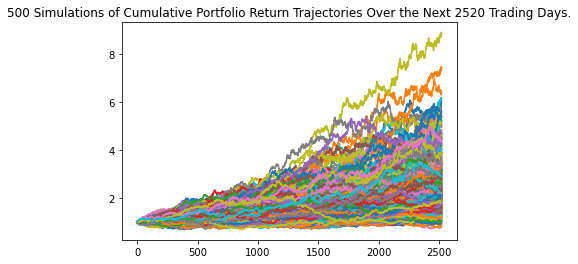

In [36]:
# Plot simulation outcomes
line_plot_10years = MC_simulation_10years.plot_simulation()

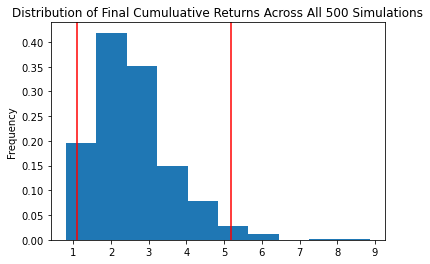

In [37]:
# Plot probability distribution and confidence intervals
dist_plot_10years = MC_simulation_10years.plot_distribution()

In [38]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_10years = MC_simulation_10years.summarize_cumulative_return()

# Print summary statistics
print(summary_10years)

count           500.000000
mean              2.604583
std               1.070796
min               0.802733
25%               1.881179
50%               2.422038
75%               3.146975
max               8.871405
95% CI Lower      1.099580
95% CI Upper      5.181255
Name: 2520, dtype: float64


In [39]:
# Set initial investment
#no code required as using initial_investment_cfo to be consistent with investment amount for comparison purposes

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(summary_10years[8]*initial_investment_cfo,2)
ci_upper_ten = round(summary_10years[9]*initial_investment_cfo,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_cfo} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 10 years will end within in the range of $21991.59 and $103625.09
